 **Required packages**

In [98]:
import numpy as np
import pandas as pd
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
import re
from nltk.corpus import stopwords
nltk.download('vader_lexicon')


from nltk.sentiment.vader import SentimentIntensityAnalyzer
from wordcloud import WordCloud
import matplotlib.pyplot as plt

from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler,  ClusterCentroids
from imblearn.metrics import classification_report_imbalanced, geometric_mean_score
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split, cross_val_score

from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import VarianceThreshold, SelectKBest, SelectFromModel, f_regression, mutual_info_regression,RFE, RFECV

from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.cluster import KMeans
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression

import joblib
from joblib import dump
from sklearn.metrics import accuracy_score


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\khari\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\khari\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\khari\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\khari\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\khari\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


**The original file is in json.gz format.Below code is given to open json file as csv.**

In [2]:
import json
import pandas as pd

def preprocess_json_file(file_path):
    data = []
    with open(file_path, 'r') as file:
        for line_number, line in enumerate(file, start=1):
            try:
                # Load each line as JSON and append to a list
                data.append(json.loads(line))
            except json.JSONDecodeError as e:
                print(f"JSONDecodeError at line {line_number}: {e}. Skipped line.")

    return data

try:
    # Preprocess JSON file
    cleaned_data = preprocess_json_file('Office_Products_5.json')

    # Create DataFrame from the list of JSON objects
    df = pd.DataFrame(cleaned_data)
    # Proceed with your DataFrame operations
    
except ValueError as e:
    print("ValueError:", e)

In [99]:
df=pd.read_csv('Amazon_office_reviews.csv') # convert dataframe to .csv file
df=df.drop('Unnamed: 0', axis=1) #drop unnecessary columns
df=df.reset_index(drop=True) #reset index

C:\Users\khari\AppData\Local\Temp\ipykernel_3852\250712487.py:1: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  df=pd.read_csv('Amazon_office_reviews.csv') # convert dataframe to .csv file


In [100]:
df.head(5) # display top 5 rows of dataframe 

,overall,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,vote,image
0,4.0,True,"11 7, 2017",A2NIJTYWADLK57,0140503528,{'Format:': ' Board book'},cotton clay,kids like story BUT while i really wanted a bo...,"good story, small size book though",1510012800,NaN,NaN
1,4.0,True,"03 7, 2017",A2827D8EEURMP4,0140503528,{'Format:': ' Hardcover'},emankcin,Bought this used and it came in great conditio...,Good,1488844800,NaN,NaN
2,5.0,True,"06 25, 2016",APB6087F4J09J,0140503528,{'Format:': ' Board book'},Starbucks Fan,Every story and book about Corduroy is Fantast...,Best Books for All Children,1466812800,NaN,NaN
3,5.0,True,"02 21, 2016",A2DHERRZIPFU7X,0140503528,{'Format:': ' Paperback'},Caitlyn Jacobson,I purchased this book for my first grade class...,Great for Math!,1456012800,NaN,NaN
4,5.0,False,"08 2, 2015",A2XCLJRGFANRC,0140503528,{'Format:': ' Hardcover'},E. Ervin,Having spent numerous years in an elementary s...,Love Corduroy,1438473600,NaN,NaN


-  overall - rating of the product
- reviewTime - time of the review (raw)
- reviewerID - ID of the reviewer, e.g. A2SUAM1J3GNN3B
- asin - ID of the product, e.g. 0000013714
- style - a disctionary of the product metadata, e.g., "Format" is "Hardcover"
- reviewerName - name of the reviewer
- reviewText - text of the review
- summary - summary of the review
- unixReviewTime - time of the review (unix time)
- vote - helpful votes of the review
- image - images that users post after they have received the product

The product ID,customer ID  , style,customer name,unix review time, image columns are to be omitted, because we do not need for next step of preprocessing

In [101]:
columns_to_omit=['reviewerID','verified','asin','style','reviewerName','summary','unixReviewTime','image'] #create variable as name of columns to be omitted

In [102]:
df=df.drop(columns_to_omit,axis=1) #drop the columns ,that wont contribute to the model analysis

In [103]:
df=df.rename(columns={'overall':'Ratings','reviewTime':'Review Time','reviewText':'Review Text','vote':'Number of response'}) # rephrase the column name

In [104]:
df['Ratings'].value_counts(normalize=True) #check the ratings column for checking balance/imbalance of dataset

Ratings
5.0    0.713423
4.0    0.153543
3.0    0.063349
1.0    0.039604
2.0    0.030082
Name: proportion, dtype: float64

New column of Sentiments to be created according to Rating column.The ratings with 5 and 4 stars are positive,whereas 1 and 2 are negative.Ratings with 3 stars will be omitted

In [105]:
df['Sentiments']=df['Ratings'].replace(to_replace=[5,4,2,1],value = ['pos','pos','neg','neg'])#assig pos and negative tags to 'ratings' column and create new column 'Sentiments'

In [106]:
df.head(2)#check for entries

,Ratings,Review Time,Review Text,Number of response,Sentiments
0,4.0,"11 7, 2017",kids like story BUT while i really wanted a bo...,NaN,pos
1,4.0,"03 7, 2017",Bought this used and it came in great conditio...,NaN,pos


The Ratings with 3 stars will be removed,because they have no interpretation.And the Ratings column will be also omittted

In [107]:
df=df.loc[df['Ratings']!=3]#omit the ratings with 3 stars

In [108]:
df=df.drop('Ratings',axis=1)#drop the 'Ratings' column

**Converting review time to day,month and year.**

In [109]:
df['Review Time'] = pd.to_datetime(df['Review Time'])  # convert the 'Review Time' column to date-time object

In [110]:
df['Month'] = df['Review Time'].dt.month #extract the column 'Month'

In [111]:
df['Year'] = df['Review Time'].dt.year #'extract the column 'Year'

Review Time column will be deleted

In [112]:
df=df.drop('Review Time',axis=1) #delete 'Review Time' column

In order to save preproccessed dataframe, new dataframe with name df_txt will be created

In [113]:
df_txt=df[:800000].copy() # save new dataframe as df_txt with 80000 entries

In [114]:
df_txt.info() #check for na values

<class 'pandas.core.frame.DataFrame'>
Index: 749655 entries, 0 to 800356
Data columns (total 5 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   Review Text         749390 non-null  object
 1   Number of response  80351 non-null   object
 2   Sentiments          749655 non-null  object
 3   Month               749655 non-null  int32 
 4   Year                749655 non-null  int32 
dtypes: int32(2), object(3)
memory usage: 28.6+ MB


In [115]:
df_txt=df_txt.dropna() #drop na values

In [116]:
df_txt.info() # recheck 

<class 'pandas.core.frame.DataFrame'>
Index: 80329 entries, 21 to 800344
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Review Text         80329 non-null  object
 1   Number of response  80329 non-null  object
 2   Sentiments          80329 non-null  object
 3   Month               80329 non-null  int32 
 4   Year                80329 non-null  int32 
dtypes: int32(2), object(3)
memory usage: 3.1+ MB


Below is the code to filter stop words from reviews

In [70]:
stop_words1 = set(stopwords.words('english'))  # setting stop words
def stop_words_filtering1(review):  # define function that takes a review as input
    preprocessed_sentences = [] # List to store preprocessed sentences

    sentences = sent_tokenize(review) # tokenize the review into sentences
    for sentence in sentences:   # iterate through each sentence in the review
        words = nltk.word_tokenize(sentence) # tokenize the sentence into words
        filtered_words = [word for word in words if word.lower() not in stop_words1]  # filter out stop words from the words list
        filtered_sentence = ' '.join(filtered_words) # join the filtered words to form a filtered sentence
        preprocessed_sentences.append(filtered_sentence) # append the filtered sentence to the list of preprocessed sentences

    return ' '.join(preprocessed_sentences)  # join the preprocessed sentences to form the final preprocessed review
df_txt['Preprocessed_text_wo_stopwords'] = df_txt['Review Text'].apply(lambda x: stop_words_filtering1(x))

In [117]:
df_txt

,Review Text,Number of response,Sentiments,Month,Year
21,That being said ...\nI do like that it keeps a...,13.0,pos,6,2014
30,"<div id=""video-block-R2Y52J3IL4TVEP"" class=""a-...",33.0,pos,3,2016
55,These Bible Book Covers make great covers for ...,69.0,pos,3,2011
63,I am always on the lookout for cool products t...,2.0,pos,9,2017
74,I purchased this for my son's Boy Scout book w...,15.0,pos,11,2015
...,...,...,...,...,...
800208,Very nice case for price. Fits all my prismac...,2.0,pos,2,2017
800250,not a DRY erase board ... I've only used the m...,2.0,neg,12,2017
800254,These are very nice inkjet labels for organiza...,3.0,pos,5,2018
800336,works great for our badges,5.0,pos,2,2018


Below is the code additional preprocessing steps.This step is to eliminate URLs, non alphanumerice characters,html tags

In [72]:
def more_preprocessing(review):
    sentences = sent_tokenize(review)   # tokenize into sentences
    preprocessed_sentences = [] # list to store preprocessed sentences

    
    lemmatizer = WordNetLemmatizer() # initialize lemmatizer

    for sentence in sentences: # Iterate through each sentence in the review
        #
        sentence = re.sub(r'http\S+|www\S+', '', sentence) # removes URLs
        sentence = re.sub('<[^<]+?>', '', sentence) # removes HTML tags
        sentence = re.sub('\[.*?\]', '', sentence)  # removes everything that is in square brackets, including the brackets
        sentence = re.sub('https?://\S+|www\.\S+', '', sentence) # removes all URLs from the text
        sentence = re.sub('<.*?>+', '', sentence)  # remove HTML tags
        sentence = re.sub('\n', '', sentence)  # removes line breaks
        sentence = re.sub('\w*\d\w*', '', sentence)  # removes all words containing numbers
        sentence = re.sub('[^\w\s]', '', sentence) # removes all non_alphanumeric characters an non-spaces

        
        words = nltk.word_tokenize(sentence) # Tokenize words
        filtered_words = [word for word in words if word.lower() not in stop_words1] # filter out stop words from the words list 
        lemmatized_words = [lemmatizer.lemmatize(word) for word in filtered_words]# lemmatization

        
        filtered_sentence = ' '.join(lemmatized_words) # join words back into a sentence
        preprocessed_sentences.append(filtered_sentence) # append the filtered sentence to the list of preprocessed sentences

    return ' '.join(preprocessed_sentences) # join the preprocessed sentences to form the final preprocessed review
df_txt['Preprocessed_review_text_final'] = df_txt['Preprocessed_text_wo_stopwords'].apply(lambda x: more_preprocessing(x)) # create the new column 'Add_Preprocessed Text'

In [118]:
df_txt

,Review Text,Number of response,Sentiments,Month,Year
21,That being said ...\nI do like that it keeps a...,13.0,pos,6,2014
30,"<div id=""video-block-R2Y52J3IL4TVEP"" class=""a-...",33.0,pos,3,2016
55,These Bible Book Covers make great covers for ...,69.0,pos,3,2011
63,I am always on the lookout for cool products t...,2.0,pos,9,2017
74,I purchased this for my son's Boy Scout book w...,15.0,pos,11,2015
...,...,...,...,...,...
800208,Very nice case for price. Fits all my prismac...,2.0,pos,2,2017
800250,not a DRY erase board ... I've only used the m...,2.0,neg,12,2017
800254,These are very nice inkjet labels for organiza...,3.0,pos,5,2018
800336,works great for our badges,5.0,pos,2,2018


This row is review text before the preprocessing steps

In [74]:
df_txt['Review Text'].iloc[0]

'That being said ...\nI do like that it keeps all things easily @ hand ...\nI do use it all week to study me Sabbath School Lesson ...\nI use it also on a weekly basis to carry lesson & Bible to church ...\nIt is good in theory ...\nNeeds to be a bit firmer in construction ...'

And this one is after the cleaning step

In [75]:
df_txt['Preprocessed_review_text_final'].iloc[0]

'said like keep thing easily hand use week study Sabbath School Lesson use also weekly basis carry lesson Bible church good theory Needs bit firmer construction'

In [76]:
df_txt.to_csv('Amazon_office_reviews_preprocessed.csv')# save the dataset as .csv file with preprocessed review column

In [119]:
df_txt=pd.read_csv('Amazon_office_reviews_preprocessed.csv') # read the .csv file
df_txt=df_txt.drop('Unnamed: 0', axis=1)

In [120]:
df_txt.head(3) #check for entries

,Review Text,Number of response,Sentiments,Month,Year,Preprocessed_text_wo_stopwords,Preprocessed_review_text_final
0,That being said ...\nI do like that it keeps a...,13.0,pos,6,2014,said ... like keeps things easily @ hand ... u...,said like keep thing easily hand use week stud...
1,"<div id=""video-block-R2Y52J3IL4TVEP"" class=""a-...",33.0,pos,3,2016,< div id= '' video-block-R2Y52J3IL4TVEP '' cla...,nbsp LOVE bible cover blue one son well One sc...
2,These Bible Book Covers make great covers for ...,69.0,pos,3,2011,Bible Book Covers make great covers Boy Scout ...,Bible Book Covers make great cover Boy Scout H...


In [121]:
df_txt2 = pd.DataFrame.reindex(df_txt,columns = ['Sentiments','Preprocessed_review_text_final']) #reindex the columns so the target column 'Sentiments' appear to be first column

In [122]:
df_txt2=df_txt2.dropna() # drop of nan values

In [123]:
df_txt2.info() #check for number of rows

<class 'pandas.core.frame.DataFrame'>
Index: 80322 entries, 0 to 80328
Data columns (total 2 columns):
 #   Column                          Non-Null Count  Dtype 
---  ------                          --------------  ----- 
 0   Sentiments                      80322 non-null  object
 1   Preprocessed_review_text_final  80322 non-null  object
dtypes: object(2)
memory usage: 1.8+ MB


In [124]:
df_txt2=df_txt2.rename(columns={'Preprocessed_review_text_final':'Final_review_text'}) #rename the 'Add_Preprocessed Text' column

In [125]:
df_txt2.to_csv('Amazon_office_reviews_preprocessed_only sentiments_and_text.csv')# save the target column 'Sentiments' and feature column 'Preprocessed Review Text' as .csv file

In [126]:
df_new=pd.read_csv('Amazon_office_reviews_preprocessed_only sentiments_and_text.csv') #read the csv file
df_new=df_new.drop('Unnamed: 0', axis=1)

In [127]:
df_new

,Sentiments,Final_review_text
0,pos,said like keep thing easily hand use week stud...
1,pos,nbsp LOVE bible cover blue one son well One sc...
2,pos,Bible Book Covers make great cover Boy Scout H...
3,pos,always lookout cool product also practical usa...
4,pos,purchased son Boy Scout book spiral binding fi...
...,...,...
80317,pos,nice case price Fits prismacolor colored penci...
80318,neg,DRY erase board used marker came eraser dry er...
80319,pos,nice inkjet label organization ended making cu...
80320,pos,work great badge


Before carrying on the the TF IDF analysis, we should label positive sentiments as 1 and negative as 0.In thin context, the Label Encoder of sklearn preprocessing step is an excellent method

In [128]:
encoder=LabelEncoder()
df_new['Sentiments']=encoder.fit_transform(df_new['Sentiments']) #encoding the 'pos' label as 1 and 'neg' label as 0


In [129]:
df_new

,Sentiments,Final_review_text
0,1,said like keep thing easily hand use week stud...
1,1,nbsp LOVE bible cover blue one son well One sc...
2,1,Bible Book Covers make great cover Boy Scout H...
3,1,always lookout cool product also practical usa...
4,1,purchased son Boy Scout book spiral binding fi...
...,...,...
80317,1,nice case price Fits prismacolor colored penci...
80318,0,DRY erase board used marker came eraser dry er...
80319,1,nice inkjet label organization ended making cu...
80320,1,work great badge



## TFIDF Unigrams

In [130]:

X_train,X_test,y_train,y_test=train_test_split(df_new['Final_review_text'],df_new['Sentiments'],test_size=0.25,random_state=123,shuffle=True) #split the data into train and test set


In [131]:
vectorizer=TfidfVectorizer(min_df=0.001,stop_words='english',ngram_range=(1,1)) # fit with TF-IDF vectorizer, with ngram_range=(1,1) which indicates  unigrams

X_train_tf=vectorizer.fit_transform(X_train) # fit and transform the training data to generate TF-IDF features
X_test_tf=vectorizer.transform(X_test) # use the same vectorizer to transform the test data based on the fitted vocabulary from the training data

There is imbalance in dataset,where positive reviews is 78%.To overcome the imbalance, RandomOversampler and Smote method is deplyed

In [132]:
import warnings
warnings.filterwarnings("ignore")
#From X_train and y_train, create two new data sets (X_ro, y_ro) and (X_sm, y_sm) obtained by Random Oversampling (RandomOverSampler) and SMOTE (SMOTE), respectively.
ros = RandomOverSampler() #initialize the RandomOversampler method
X_ro, y_ro = ros.fit_resample(X_train_tf, y_train) #fit resample the train set
smo = SMOTE() #initialize the SMOTE method
X_sm, y_sm = smo.fit_resample(X_train_tf, y_train) #fit resample the train_set

  File "C:\Users\khari\miniconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "C:\Users\khari\miniconda3\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\khari\miniconda3\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "C:\Users\khari\miniconda3\Lib\subprocess.py", line 1538, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(executable, args,
                       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


## Machine Learning Methods

<span style="font-size: 14pt;">Below LogisticRegression,BalancedRandonForestClassifier and GradientBoostingClassifier</span>

In [14]:
lr=LogisticRegression (max_iter=200) #Logistic Regression with 200 iterations
brf=BalancedRandomForestClassifier () #Balanced Random Forest Classifier
gbc= GradientBoostingClassifier()#Gradient Boosing Classifier

<span style="font-size: 14pt;">Below is creation of 3 parameters grid<span>

In [95]:
  param_grid_lr = {'solver': ['lbfgs', 'liblinear' ,'saga'], 'C': np.arange(0,1,0.2),
                   'penalty':['l1','l2']}  # initialize parameter grid for logisticsregression

  param_grid_brf = {'n_estimators': [10, 50, 100, 250, 500, 1000],
                        'max_leaf_nodes': [1, 3, 5],
                         'criterion':['gini', 'entropy']} # initialize parameter grid for balanced random classifier

  param_grid_gbc = {'loss':['log_loss','exponential'],
                    'n_estimators':np.arange(0,100,20),
                     'criterion':['friedman_mse', 'squared_error'],
                     'max_depth':np.arange(0,10,1),
                     'max_features':['sqrt', 'log2']} # initialize parameter grid for gradient boosting classifier
                    


 <span style="font-size: 14pt;">Instantiate for each pair of model and grid, a GridSearchCV and save it as an element of gridcvs with a key corresponding to the name of the algorithm used.Below LogisticRegression,BalancedRandonForestClassifier and XGBClassifier</span>

In [16]:
#1
gridcvs = {} # create an empty dictionary gridcvs.

# Instantiate for each pair of model and grid, a GridSearchCV and save it as an element of gridcvs with a key corresponding to the name of the algorithm used.
for pgrid, clf, name in zip((param_grid_lr, param_grid_brf, param_grid_gbc),
                             (lr,brf,gbc),
                             ('LogisticRegression', 'BalancedRandomForest', 'GradientBoostingClassifier')):
    gcv = GridSearchCV(clf, pgrid, cv=5, refit=True)
    gridcvs[name] = gcv
gridcvs

{'LogisticRegression': GridSearchCV(cv=5, estimator=LogisticRegression(max_iter=200),
              param_grid={'C': array([0. , 0.2, 0.4, 0.6, 0.8]),
                          'penalty': ['l1', 'l2'],
                          'solver': ['lbfgs', 'liblinear', 'saga']}),
 'BalancedRandomForest': GridSearchCV(cv=5, estimator=BalancedRandomForestClassifier(),
              param_grid={'criterion': ['gini', 'entropy'],
                          'max_leaf_nodes': [1, 3, 5],
                          'n_estimators': [10, 50, 100, 250, 500, 1000]}),
 'GradientBoostingClassifier': GridSearchCV(cv=5, estimator=GradientBoostingClassifier(),
              param_grid={'criterion': ['friedman_mse', 'squared_error'],
                          'loss': ['log_loss', 'exponential'],
                          'max_depth': array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
                          'max_features': ['sqrt', 'log2'],
                          'n_estimators': array([ 0, 20, 40, 60, 80])})}

In [53]:
model_lr_ro = gridcvs['LogisticRegression'] #initialize the Logisctisc Regression as first key of gridcvs dictonary
model_lr_ro.fit(X_ro,y_ro) # fit the the X_ro and y_ro as randomly undersampled X_train,y_train 

"\nmodel_lr_ro = gridcvs['LogisticRegression']\nmodel_lr_ro.fit(X_ro,y_ro)\n"

In [18]:
model_lr_ro=joblib.load('logistic_regression_model_ro.joblib') #upload the saved model

In [19]:
model_lr_ro

GridSearchCV(cv=5, estimator=LogisticRegression(max_iter=200),
             param_grid={'C': array([0. , 0.2, 0.4, 0.6, 0.8]),
                         'penalty': ['l1', 'l2'],
                         'solver': ['lbfgs', 'liblinear', 'saga']})

In [20]:
#Test for best parameters and find  train and test set model accuracy
print(f'Best Parameters: {model_lr_ro .best_params_}')
train_acc = accuracy_score(y_true=y_train, y_pred=model_lr_ro.predict(X_train_tf))
test_acc = accuracy_score(y_true=y_test, y_pred=model_lr_ro.predict(X_test_tf))
print(f'Training Accuracy: {100*train_acc:.2f}')
print(f'Test Accuracy: {100*test_acc:.2f}')

Best Parameters: {'C': 0.8, 'penalty': 'l2', 'solver': 'liblinear'}
Training Accuracy: 86.76
Test Accuracy: 89.84


In [21]:
model_lr_sm = gridcvs['LogisticRegression'] # initialize the Logisctisc Regression as first key of gridcvs dictonary
model_lr_sm.fit(X_sm,y_sm) # fit the the X_ro and y_ro as randomly undersampled X_train,y_train 

"\nmodel_lr_sm = gridcvs['LogisticRegression']\nmodel_lr_sm.fit(X_sm,y_sm)\n"

In [22]:
model_lr_sm=joblib.load('logistics_regression_model_sm.joblib') # load the saved model

In [23]:
#Test for best parameters and find  train and test set model accuracy
print(f'Best Parameters: {model_lr_sm .best_params_}')

train_acc = accuracy_score(y_true=y_train, y_pred=model_lr_sm.predict(X_train_tf))
test_acc = accuracy_score(y_true=y_test, y_pred=model_lr_sm.predict(X_test_tf))

print(f'Training Accuracy: {100*train_acc:.2f}')
print(f'Test Accuracy: {100*test_acc:.2f}')

Best Parameters: {'C': 0.8, 'penalty': 'l1', 'solver': 'liblinear'}
Training Accuracy: 89.73
Test Accuracy: 87.87


In [15]:
model_brf_ro=gridcvs['BalancedRandomForest']
model_brf_ro.fit(X_ro,y_ro)

GridSearchCV(cv=5, estimator=BalancedRandomForestClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_leaf_nodes': [1, 3, 5],
                         'n_estimators': [10, 50, 100, 250, 500, 1000]})

In [28]:
model_brf_ro=model_gbc_ro=joblib.load('balanced_random_forest_model_ro.joblib')

In [29]:
print(f'Best Parameters: {model_brf_ro .best_params_}')

train_acc = accuracy_score(y_true=y_train, y_pred=model_brf_ro.predict(X_train_tf))
test_acc = accuracy_score(y_true=y_test, y_pred=model_brf_ro.predict(X_test_tf))

print(f'Training Accuracy: {100*train_acc:.2f}')
print(f'Test Accuracy: {100*test_acc:.2f}')

Best Parameters: {'criterion': 'entropy', 'max_leaf_nodes': 5, 'n_estimators': 500}
Training Accuracy: 79.46
Test Accuracy: 78.48


In [ ]:
model_brf_sm=gridcvs['BalancedRandomForest']
model_brf_sm.fit(X_sm,y_sm)

In [ ]:
model_brf_sm=joblib.load('balanced_random_forest_model_sm.joblib')

In [17]:
print(f'Best Parameters: {model_brf_sm .best_params_}')

train_acc = accuracy_score(y_true=y_train, y_pred=model_brf_sm.predict(X_train_tf))
test_acc = accuracy_score(y_true=y_test, y_pred=model_brf_sm.predict(X_test_tf))

print(f'Training Accuracy: {100*train_acc:.2f}')
print(f'Test Accuracy: {100*test_acc:.2f}')

Best Parameters: {'criterion': 'gini', 'max_leaf_nodes': 5, 'n_estimators': 1000}
Training Accuracy: 81.45
Test Accuracy: 81.95


In [52]:
model_gbc_ro=gridcvs['GradientBoostingClassifier'] # initialize the Gradient Boosting Classifier as second key of gridcvs dictonary
model_gbc_ro.fit(X_ro,y_ro) # fit the the X_ro and y_ro as randomly undersampled X_train,y_train 

"\nmodel_gbc_ro=gridcvs['GradientBoostingClassifier']\nmodel_gbc_ro.fit(X_ro,y_ro)\n"

In [25]:
model_gbc_ro=joblib.load('gradientboosting_model_ro.joblib') # load the saved model

In [30]:
#Test for best parameters and find  train and test set model accuracy
print(f'Best Parameters: {model_gbc_sm .best_params_}')

train_acc = accuracy_score(y_true=y_train, y_pred=model_gbc_sm.predict(X_train_tf))
test_acc = accuracy_score(y_true=y_test, y_pred=model_gbc_sm.predict(X_test_tf))

print(f'Training Accuracy: {100*train_acc:.2f}')
print(f'Test Accuracy: {100*test_acc:.2f}')

Best Parameters: {'criterion': 'friedman_mse', 'loss': 'log_loss', 'max_depth': 9, 'max_features': 'sqrt', 'n_estimators': 80}
Training Accuracy: 87.00
Test Accuracy: 84.06


In [26]:
#Test for best parameters and find  train and test set model accuracy
print(f'Best Parameters: {model_gbc_ro .best_params_}')

train_acc = accuracy_score(y_true=y_train, y_pred=model_gbc_ro.predict(X_train_tf))
test_acc = accuracy_score(y_true=y_test, y_pred=model_gbc_ro.predict(X_test_tf))

print(f'Training Accuracy: {100*train_acc:.2f}')
print(f'Test Accuracy: {100*test_acc:.2f}')

Best Parameters: {'criterion': 'squared_error', 'loss': 'log_loss', 'max_depth': 9, 'max_features': 'sqrt', 'n_estimators': 80}
Training Accuracy: 86.41
Test Accuracy: 82.97


In [27]:
model_gbc_sm=gridcvs['GradientBoostingClassifier'] # initialize the Gradient Boosting Classifier as third key of gridcvs dictonary
model_gbc_sm.fit(X_sm,y_sm) # fit the the X_ro and y_ro as randomly undersampled X_train,y_train 

GridSearchCV(cv=5, estimator=GradientBoostingClassifier(),
             param_grid={'criterion': ['friedman_mse', 'squared_error'],
                         'loss': ['log_loss', 'exponential'],
                         'max_depth': array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
                         'max_features': ['sqrt', 'log2'],
                         'n_estimators': array([ 0, 20, 40, 60, 80])})

In [29]:
model_gbc_sm=model_gbc_ro=joblib.load('gradientboosting_model_sm.joblib') # load the saved model

## Machine Learning with bigrams


## TFIDF Bigrams

In [14]:
vectorizer2=TfidfVectorizer(min_df=0.001,stop_words='english',ngram_range=(2,2)) #initialize the vectorizer with  bigrams
X_train_tf_2=vectorizer2.fit_transform(X_train)
X_test_tf_2=vectorizer2.transform(X_test)

In [15]:
import warnings
warnings.filterwarnings("ignore")
#From X_train and y_train, create two new data sets (X_ro, y_ro) and (X_sm, y_sm) obtained by Random Oversampling (RandomOverSampler) and SMOTE (SMOTE), respectively.
ros = RandomOverSampler() # initialize Random Oversampler
X_ro_2, y_ro_2 = ros.fit_resample(X_train_tf_2, y_train) # fit and resample train data

smo = SMOTE()
X_sm_2, y_sm_2 = smo.fit_resample(X_train_tf_2, y_train) # fit and resample train data

In [24]:
model_lr_ro_2 = gridcvs['LogisticRegression'] # initialize the Logisctics Regression as firts key of gridcvs dictonary
model_lr_ro_2.fit(X_ro_2,y_ro_2) # fit the the X_ro_2 and y_ro_2 as randomly undersampled X_train,y_train 

GridSearchCV(cv=5, estimator=LogisticRegression(max_iter=200),
             param_grid={'C': array([0. , 0.2, 0.4, 0.6, 0.8]),
                         'penalty': ['l1', 'l2'],
                         'solver': ['lbfgs', 'liblinear', 'saga']})

In [ ]:
model_lr_ro_2=joblib.load('logistics_regression_model_ro_2.joblib') #load the model

In [26]:
#Test for best parameters and find  train and test set model accuracy
print(f'Best Parameters: {model_lr_ro_2 .best_params_}')

train_acc = accuracy_score(y_true=y_train, y_pred=model_lr_ro_2.predict(X_train_tf_2))
test_acc = accuracy_score(y_true=y_test, y_pred=model_lr_ro_2.predict(X_test_tf_2))

print(f'Training Accuracy: {100*train_acc:.2f}')
print(f'Test Accuracy: {100*test_acc:.2f}')

Best Parameters: {'C': 0.8, 'penalty': 'l1', 'solver': 'saga'}
Training Accuracy: 77.82
Test Accuracy: 75.15


In [33]:
model_lr_sm_2 = gridcvs['LogisticRegression'] # initialize the Logisctics Regression as firts key of gridcvs dictonary
model_lr_sm_2.fit(X_sm_2,y_sm_2) # fit the the X_ro_2 and y_ro_2 as randomly undersampled X_train,y_train 

GridSearchCV(cv=5, estimator=LogisticRegression(max_iter=200),
             param_grid={'C': array([0. , 0.2, 0.4, 0.6, 0.8]),
                         'penalty': ['l1', 'l2'],
                         'solver': ['lbfgs', 'liblinear', 'saga']})

In [35]:
model_lr_sm_2=joblib.load('logistics_regression_model_sm_2.joblib') #load the model

In [36]:
#Test for best parameters and find  train and test set model accuracy
print(f'Best Parameters: {model_lr_sm_2 .best_params_}')

train_acc = accuracy_score(y_true=y_train, y_pred=model_lr_sm_2.predict(X_train_tf_2))
test_acc = accuracy_score(y_true=y_test, y_pred=model_lr_sm_2.predict(X_test_tf_2))

print(f'Training Accuracy: {100*train_acc:.2f}')
print(f'Test Accuracy: {100*test_acc:.2f}')

Best Parameters: {'C': 0.8, 'penalty': 'l2', 'solver': 'liblinear'}
Training Accuracy: 79.40
Test Accuracy: 77.04


In [30]:
model_gbc_ro_2=gridcvs['GradientBoostingClassifier'] # initialize the Gradient Boosting Classifier as second key of gridcvs dictonary
model_gbc_ro_2.fit(X_ro_2,y_ro_2) # fit the the X_ro_2 and y_ro_2 as randomly undersampled X_train,y_train 

GridSearchCV(cv=5, estimator=GradientBoostingClassifier(),
             param_grid={'criterion': ['friedman_mse', 'squared_error'],
                         'loss': ['log_loss', 'exponential'],
                         'max_depth': array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
                         'max_features': ['sqrt', 'log2'],
                         'n_estimators': array([ 0, 20, 40, 60, 80])})

In [37]:
model_gbc_ro_2=joblib.load('gradient_boosting_model_ro_2.joblib') #load the model

In [38]:
#Test for best parameters and find  train and test set model accuracy
print(f'Best Parameters: {model_gbc_ro_2 .best_params_}')

train_acc = accuracy_score(y_true=y_train, y_pred=model_gbc_ro_2.predict(X_train_tf_2))
test_acc = accuracy_score(y_true=y_test, y_pred=model_gbc_ro_2.predict(X_test_tf_2))

print(f'Training Accuracy: {100*train_acc:.2f}')
print(f'Test Accuracy: {100*test_acc:.2f}')

Best Parameters: {'criterion': 'friedman_mse', 'loss': 'log_loss', 'max_depth': 9, 'max_features': 'log2', 'n_estimators': 80}
Training Accuracy: 66.49
Test Accuracy: 64.42


In [43]:
model_gbc_sm_2=gridcvs['GradientBoostingClassifier'] # initialize the Gradient Boosting Classifier as second key of gridcvs dictonary
model_gbc_sm_2.fit(X_ro_2,y_ro_2) # fit the the X_ro_2 and y_ro_2 as randomly undersampled X_train,y_train 

GridSearchCV(cv=5, estimator=GradientBoostingClassifier(),
             param_grid={'criterion': ['friedman_mse', 'squared_error'],
                         'loss': ['log_loss', 'exponential'],
                         'max_depth': array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
                         'max_features': ['sqrt', 'log2'],
                         'n_estimators': array([ 0, 20, 40, 60, 80])})

In [45]:
model_gbc_sm_2=joblib.load('gradient_boosting_model_sm_2.joblib') # load the model

In [46]:
#Test for best parameters and find  train and test set model accuracy
print(f'Best Parameters: {model_gbc_sm_2 .best_params_}')

train_acc = accuracy_score(y_true=y_train, y_pred=model_gbc_sm_2.predict(X_train_tf_2))
test_acc = accuracy_score(y_true=y_test, y_pred=model_gbc_sm_2.predict(X_test_tf_2))

print(f'Training Accuracy: {100*train_acc:.2f}')
print(f'Test Accuracy: {100*test_acc:.2f}')

Best Parameters: {'criterion': 'friedman_mse', 'loss': 'log_loss', 'max_depth': 9, 'max_features': 'log2', 'n_estimators': 80}
Training Accuracy: 66.69
Test Accuracy: 64.45


In [48]:
model_brf_ro_2=gridcvs['BalancedRandomForest'] # initialize the Balanced Random Classifier as third key of gridcvs dictonary
model_brf_ro_2.fit(X_ro_2,y_ro_2) # fit the the X_ro_2 and y_ro_2 as randomly undersampled X_train,y_train 

GridSearchCV(cv=5, estimator=BalancedRandomForestClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_leaf_nodes': [1, 3, 5],
                         'n_estimators': [10, 50, 100, 250, 500, 1000]})

In [50]:
model_brf_ro_2=joblib.load('balanced_random_forest_model_ro_2.joblib') # load the model

In [51]:
#Test for best parameters and find  train and test set model accuracy
print(f'Best Parameters: {model_brf_ro_2 .best_params_}')

train_acc = accuracy_score(y_true=y_train, y_pred=model_brf_ro_2.predict(X_train_tf_2))
test_acc = accuracy_score(y_true=y_test, y_pred=model_brf_ro_2.predict(X_test_tf_2))

print(f'Training Accuracy: {100*train_acc:.2f}')
print(f'Test Accuracy: {100*test_acc:.2f}')

Best Parameters: {'criterion': 'entropy', 'max_leaf_nodes': 5, 'n_estimators': 500}
Training Accuracy: 59.56
Test Accuracy: 58.57


## TF-IDF Unigrams and Bigrams

In [20]:
vectorizer3=TfidfVectorizer(min_df=0.001,stop_words='english',ngram_range=(1,2)) # fit with TF-IDF vectorizer, with ngram_range=(1,2) which indicates  unigrams
X_train_tf_3=vectorizer3.fit_transform(X_train)
X_test_tf_3=vectorizer3.transform(X_test)

In [21]:
X_train_tf_3.shape

(60241, 7105)

In [22]:
X_test_tf_3.shape

(20081, 7105)

In [23]:
import warnings
warnings.filterwarnings("ignore")
smo = SMOTE()
X_sm_3, y_sm_3 = smo.fit_resample(X_train_tf_3, y_train)

In [96]:
lr_updated=LogisticRegression (max_iter=100,C=0.8, penalty='l2',solver='liblinear') # Logistic Regression with predefined parameters
brf_updated=BalancedRandomForestClassifier (criterion='gini',max_leaf_nodes=5,n_estimators=1000) # Balanced Random Forest Classifier with predefined parameters
gbc_updated= GradientBoostingClassifier(criterion='friedman_mse', loss='log_loss',max_depth=9,max_features='sqrt', n_estimators=80) #Gradient Boosing Classifier with predefined parameters

In [25]:
lr_updated.fit(X_sm_3,y_sm_3) # fit the the X_sm_3 and y_sm_3 as randomly undersampled set of X_train,y_train 

LogisticRegression(C=0.8, solver='liblinear')

In [36]:
lr_updated=joblib.load('logistics_regression_model_sm_3.joblib')

In [28]:
# Find  train and test set model accuracy
train_acc = accuracy_score(y_true=y_train, y_pred=lr_updated.predict(X_train_tf_3))
test_acc = accuracy_score(y_true=y_test, y_pred=lr_updated.predict(X_test_tf_3))

print(f'Training Accuracy: {100*train_acc:.2f}')
print(f'Test Accuracy: {100*test_acc:.2f}')

Training Accuracy: 90.43
Test Accuracy: 88.39


In [29]:
brf_updated.fit(X_sm_3,y_sm_3) # fit the the X_sm_3 and y_sm_3 as randomly undersampled set of X_train,y_train 

BalancedRandomForestClassifier(max_leaf_nodes=5, n_estimators=1000)

In [37]:
brf_updated=joblib.load('balanced_random_forest_model_sm_3.joblib') # load the model

In [32]:
# Find  train and test set model accuracy
train_acc = accuracy_score(y_true=y_train, y_pred=brf_updated.predict(X_train_tf_3))
test_acc = accuracy_score(y_true=y_test, y_pred=brf_updated.predict(X_test_tf_3))

print(f'Training Accuracy: {100*train_acc:.2f}')
print(f'Test Accuracy: {100*test_acc:.2f}')

Training Accuracy: 79.27
Test Accuracy: 79.05


In [33]:
gbc_updated.fit(X_sm_3,y_sm_3) # fit the the X_sm_3 and y_sm_3 as randomly undersampled set of X_train,y_train 

GradientBoostingClassifier(max_depth=9, max_features='sqrt', n_estimators=80)

In [38]:
gbc_updated=joblib.load('gradient_boosting_model_sm_3.joblib') # load the model

In [35]:
# Find  train and test set model accuracy
train_acc = accuracy_score(y_true=y_train, y_pred=gbc_updated.predict(X_train_tf_3))
test_acc = accuracy_score(y_true=y_test, y_pred=gbc_updated.predict(X_test_tf_3))

print(f'Training Accuracy: {100*train_acc:.2f}')
print(f'Test Accuracy: {100*test_acc:.2f}')

Training Accuracy: 87.27
Test Accuracy: 84.43


## WORD CLOUDS

In [97]:
text=''
for comment in df_new['Final_review_text']:
    text+=comment

KeyboardInterrupt: 

In [49]:
wc = WordCloud(background_color='black', max_words=100, stopwords = stop_words1, 
               max_font_size=50, random_state=42)

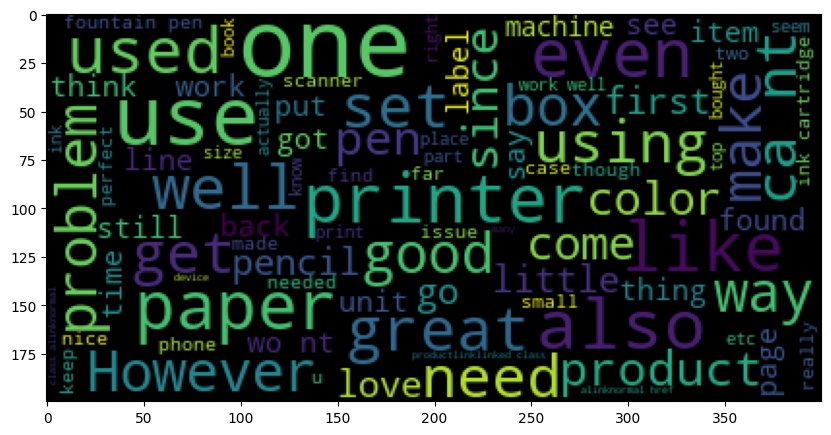

In [50]:
plt.figure(figsize= (10,6)) # Initialization of a figure
wc.generate(text)           # "Calculation" of the wordcloud
plt.imshow(wc) # Display
plt.show()


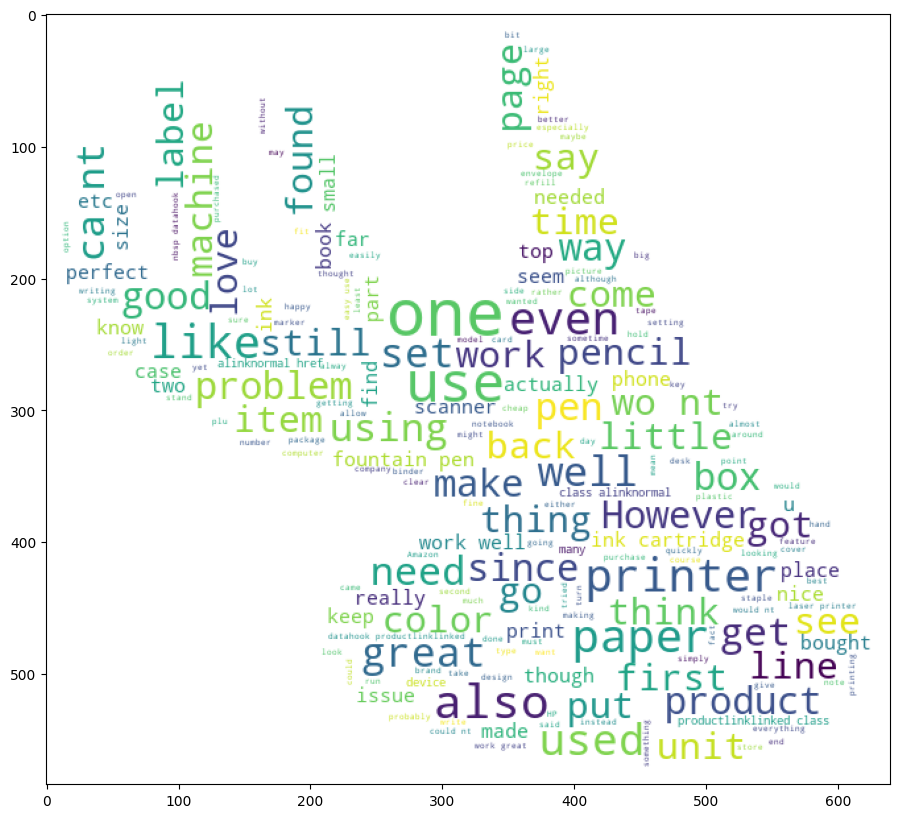

In [51]:
from PIL import Image
import numpy as np

def plot_word_cloud(text, mask, background_color = "white") :
    # Define a mask
    mask_coloring = np.array(Image.open(str(mask)))

    # Define the layer of the word cloud
    wc = WordCloud(background_color=background_color, max_words=200, stopwords=stop_words1, mask = mask_coloring, max_font_size=50, random_state=42)
    
    # Generate and display the word cloud
    plt.figure(figsize= (20,10))
    wc.generate(text)
    plt.imshow(wc)
    plt.show()

plot_word_cloud(text, "iron.jpg")



In [55]:
df_pos = df_new[df_new['Sentiments']==1]
df_neg = df_new[df_new['Sentiments']==0]

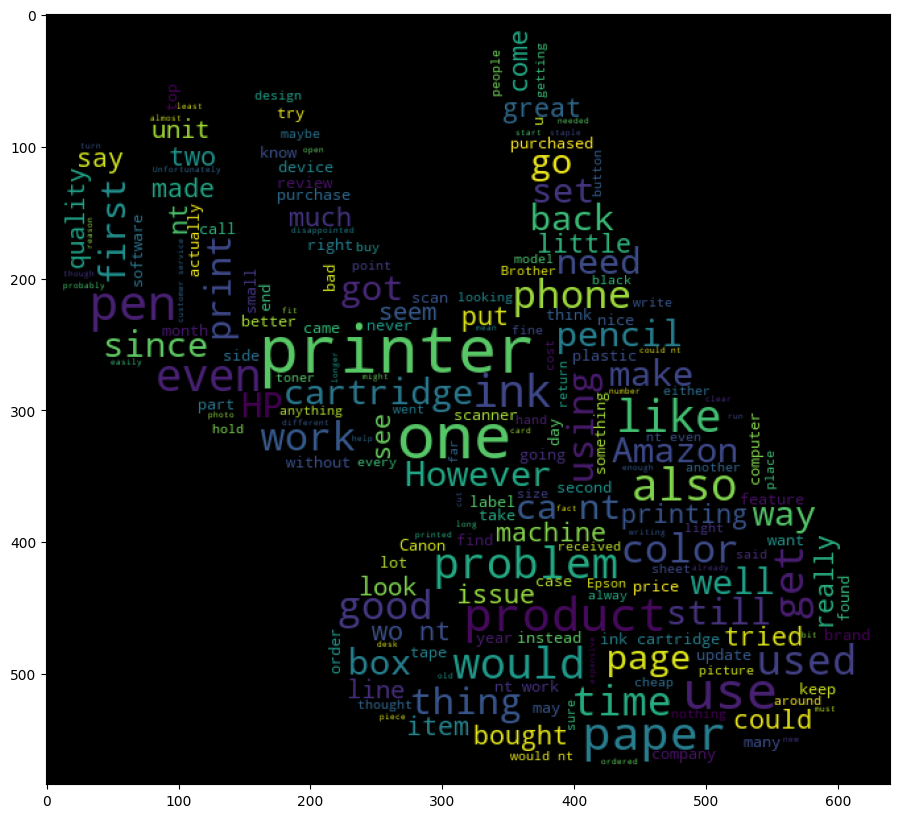

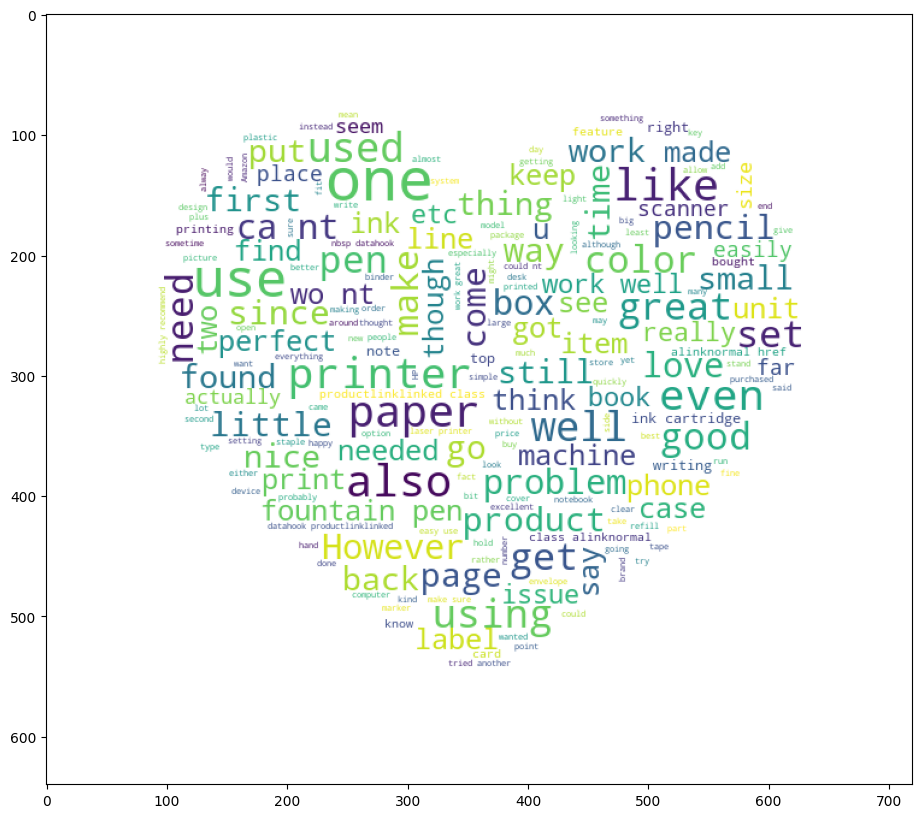

In [57]:
text_pos = ""
for words in df_pos['Add_Preprocessed Text']:
    text_pos +=words

text_neg = "" 
for words in df_neg['Add_Preprocessed Text']:
    text_neg +=words  

plot_word_cloud(text_neg, "iron.jpg","black")
plot_word_cloud(text_pos, "heart.png", "white")

Text(0.5, 1.0, '15 words most frequently used by Internet users leaving good comments')

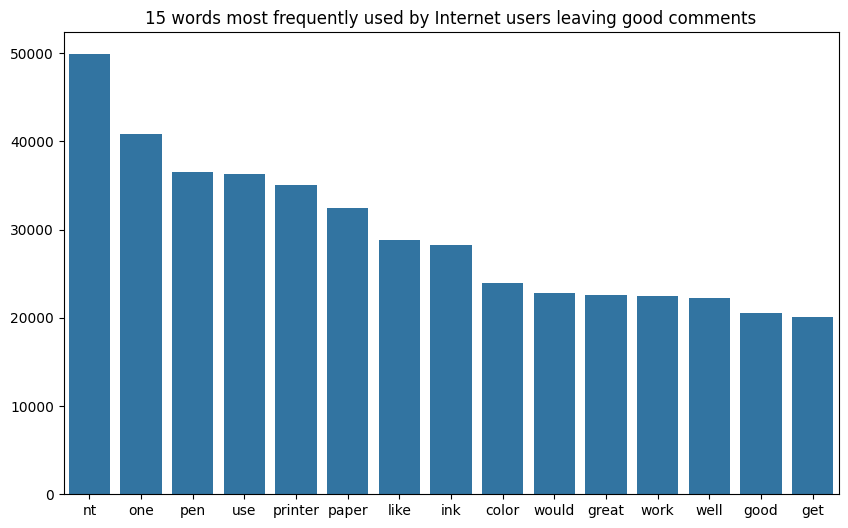

In [60]:
# Insert your code here 
from collections import Counter
import seaborn as sns

string = ''.join(i.lower() for i in df_pos['Add_Preprocessed Text'])
dico = Counter(string.split())
mots = [m[0] for m in dico.most_common(15)]
freq = [m[1] for m in dico.most_common(15)]       
                 
plt.figure(figsize= (10,6))
sns.barplot(x=mots, y=freq)     
plt.title('15 words most frequently used by Internet users leaving good comments')

Text(0.5, 1.0, '15 words most frequently used by Internet users leaving bad comments')

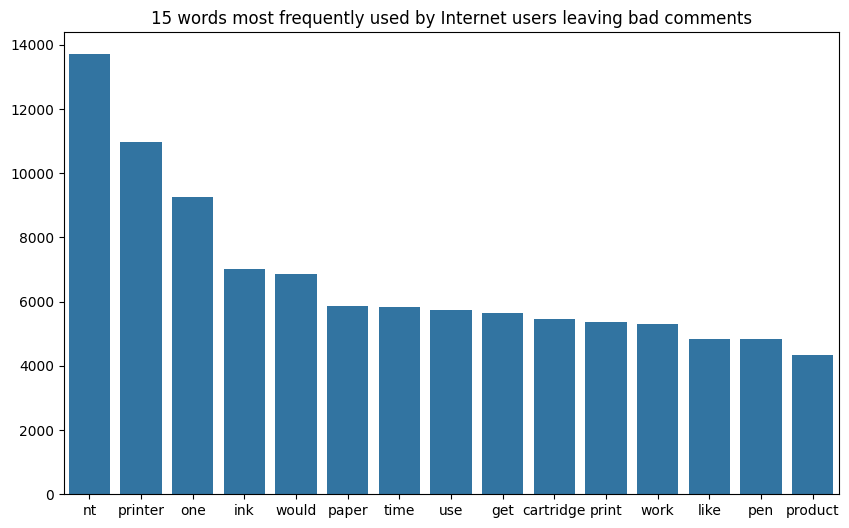

In [61]:
string = ''.join(i.lower() for i in df_neg['Add_Preprocessed Text'])
dico = Counter(string.split())
mots = [m[0] for m in dico.most_common(15)]
freq = [m[1] for m in dico.most_common(15)]       
                 
plt.figure(figsize= (10,6))
sns.barplot(x=mots, y=freq)     
plt.title('15 words most frequently used by Internet users leaving bad comments')